<a href="https://colab.research.google.com/github/Ignaciojeda/ProyectoCSSCrisDm/blob/main/Decision_Tree_Clasificacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Librerías generales
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report, roc_auc_score, mean_absolute_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

url = '/content/drive/MyDrive/TG_Machine_Learning/datos_datacss.csv'
# Cargar los datos
try:
    data = pd.read_csv(url, sep=",", encoding='latin-1', low_memory=False)
    print("Datos cargados exitosamente!")
except Exception as e:
    print(f"Error al cargar los datos: {e}")

Mounted at /content/drive
Datos cargados exitosamente!


In [ ]:
data.head(50)

,Map,Team,InternalTeamId,MatchId,RoundId,RoundWinner,MatchWinner,Survived,AbnormalMatch,RLethalGrenadesThrown,...,RoundHeadshots,RoundFlankKills,RoundStartingEquipmentValue,TeamStartingEquipmentValue,MatchKills,MatchFlankKills,MatchAssists,MatchHeadshots,outlier,MatchResult
0,de_inferno,Terrorist,1,4,1,False,True,False,False,0,...,0,0,750,4400,0,0,0,0,0,Ganados
1,de_inferno,Terrorist,1,4,1,False,True,False,False,0,...,0,0,800,4400,0,0,0,0,0,Ganados
2,de_inferno,Terrorist,1,4,1,False,True,False,False,0,...,0,0,1000,4400,0,0,0,0,0,Ganados
3,de_inferno,Terrorist,1,4,1,False,True,False,False,0,...,0,0,850,4400,0,0,0,0,0,Ganados
4,de_inferno,Terrorist,1,4,1,False,True,True,False,1,...,0,0,1000,4400,0,0,0,0,0,Ganados
5,de_inferno,CounterTerrorist,2,4,1,True,False,True,False,0,...,0,0,850,3750,0,0,0,0,0,Perdidos
6,de_inferno,CounterTerrorist,2,4,1,True,False,True,False,0,...,0,0,400,3750,0,0,0,0,0,Perdidos
7,de_inferno,CounterTerrorist,2,4,1,True,False,True,False,0,...,0,0,800,3750,0,0,1,0,0,Perdidos
8,de_inferno,CounterTerrorist,2,4,1,True,False,True,False,0,...,1,1,850,3750,3,1,0,1,0,Perdidos
9,de_inferno,CounterTerrorist,2,4,1,True,False,True,False,0,...,2,0,850,3750,2,0,0,2,0,Perdidos


#Preparación del dataset

In [ ]:
# Codificar variable MatchResult (Ganados = 1)
le = LabelEncoder()
data['MatchResult'] = le.fit_transform(data['MatchResult'])
if le.classes_[0] == 'Ganados':  # Asegura que 'Ganados' sea 1
    data['MatchResult'] = 1 - data['MatchResult']



In [ ]:
features = [
    'RLethalGrenadesThrown',
    'RoundKills',
    'RoundAssists',
    'RoundHeadshots',
    'RoundFlankKills',
    'Survived',
    'RoundStartingEquipmentValue',
    'TeamStartingEquipmentValue',
    'MatchKills',
    'MatchFlankKills',
    'MatchAssists',
    'MatchHeadshots',
    'outlier'
]

scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])


In [ ]:
df_agg = data.groupby(['MatchId', 'InternalTeamId', 'MatchResult']).agg(
    Avg_RLethalGrenadesThrown=('RLethalGrenadesThrown', 'mean'),
    Sum_RoundKills=('RoundKills', 'sum'),
    Sum_RoundAssists=('RoundAssists', 'sum'),
    Avg_RoundHeadshots=('RoundHeadshots', 'mean'),
    Avg_RoundFlankKills=('RoundFlankKills', 'mean'),
    Avg_Survived=('Survived', 'mean'),
    Avg_RoundStartingEquipmentValue=('RoundStartingEquipmentValue', 'mean'),
    Avg_TeamStartingEquipmentValue=('TeamStartingEquipmentValue', 'mean'),
    Sum_MatchKills=('MatchKills', 'first'),
    Sum_MatchFlankKills=('MatchFlankKills', 'first'),
    Sum_MatchAssists=('MatchAssists', 'first'),
    Sum_MatchHeadshots=('MatchHeadshots', 'first'),
    Avg_outlier=('outlier', 'mean')
).reset_index()

X = df_agg.drop(columns=['MatchId', 'InternalTeamId', 'MatchResult'])
y = df_agg['MatchResult']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


In [ ]:


clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred = clf.predict(X_test)

##Matriz de confusion

In [ ]:


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.915

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       105
           1       0.88      0.96      0.91        95

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200


Matriz de confusión:
[[92 13]
 [ 4 91]]


#Visualizacion del arbol

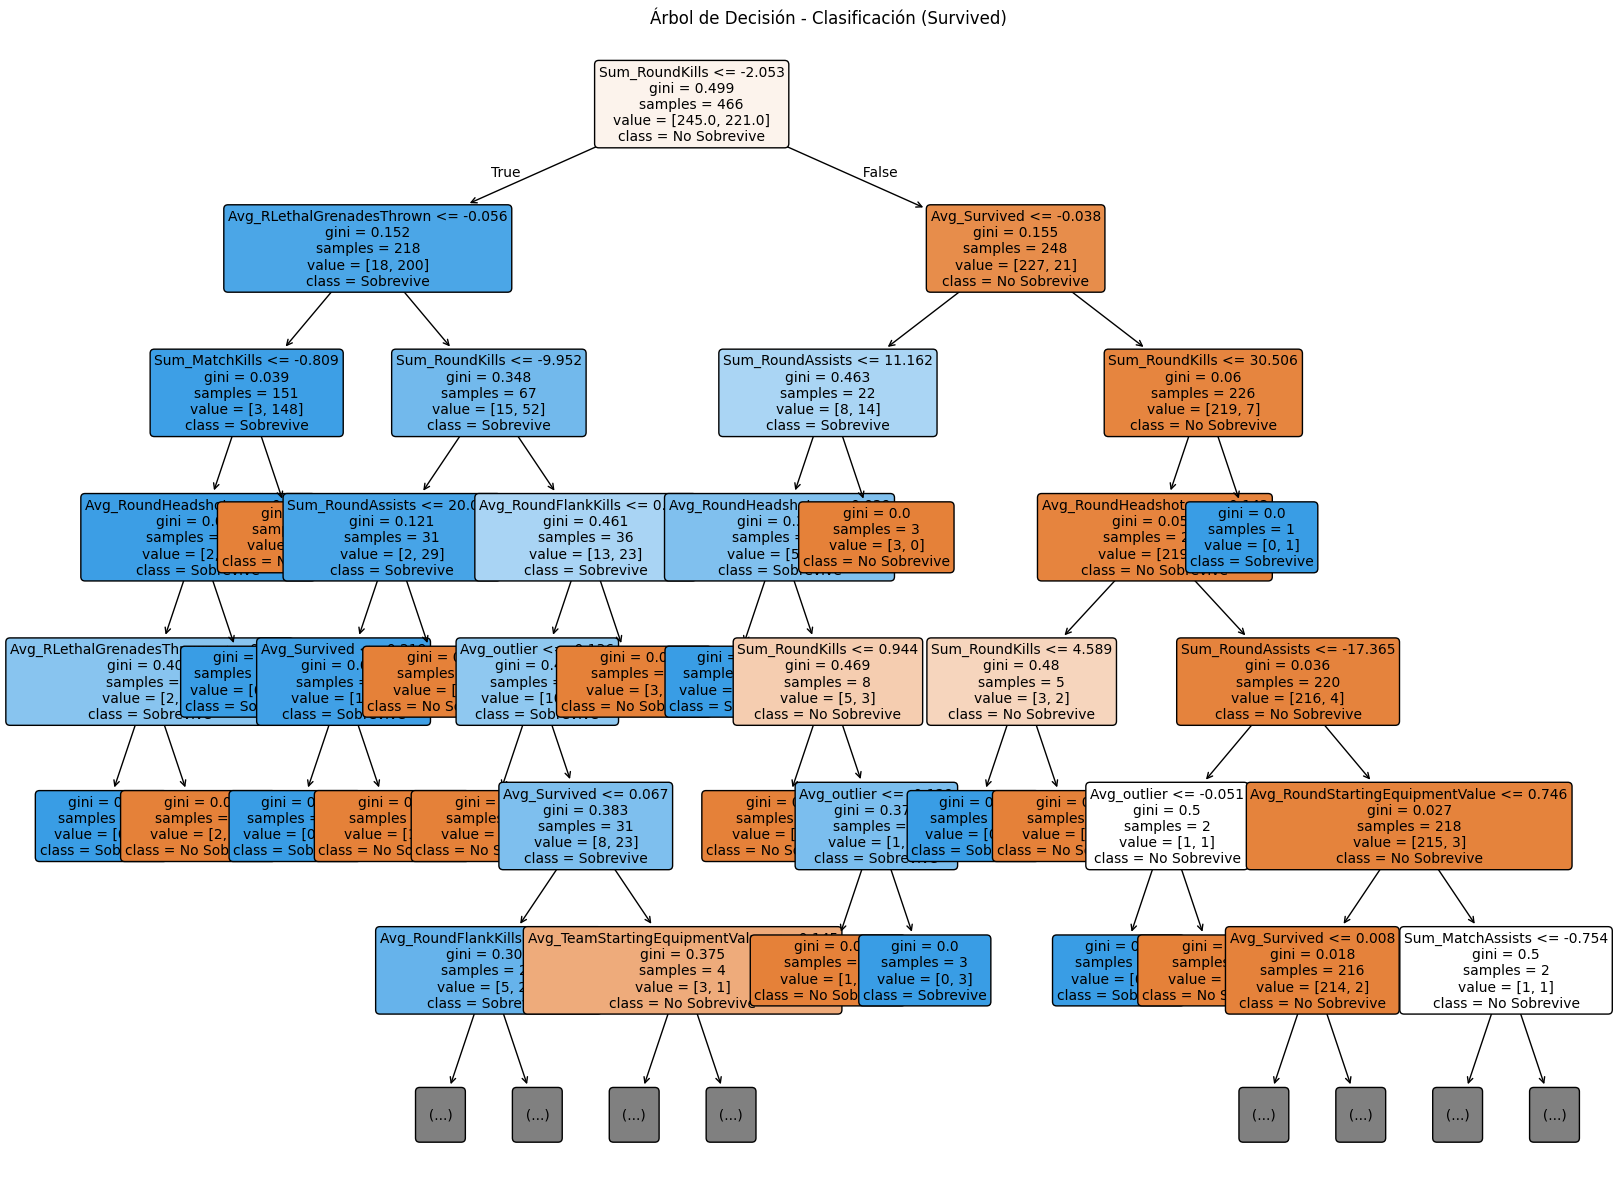

In [ ]:
plt.figure(figsize=(20, 15))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=['No Sobrevive', 'Sobrevive'],
    filled=True,
    rounded=True,
    max_depth=6,
    fontsize=10,

)
plt.title("Árbol de Decisión - Clasificación (Survived)")
plt.show()


##Importacion de los valores a la hora de predecir

In [ ]:
importancias = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': clf.feature_importances_
})

# Ordenarlo de mayor a menor importancia
importancias = importancias.sort_values(by='Importancia', ascending=False)

print(importancias)

                           Variable  Importancia
1                    Sum_RoundKills     0.741280
5                      Avg_Survived     0.094447
4               Avg_RoundFlankKills     0.035264
2                  Sum_RoundAssists     0.030849
0         Avg_RLethalGrenadesThrown     0.028919
3                Avg_RoundHeadshots     0.026394
12                      Avg_outlier     0.019659
8                    Sum_MatchKills     0.008323
7    Avg_TeamStartingEquipmentValue     0.006455
10                 Sum_MatchAssists     0.004303
6   Avg_RoundStartingEquipmentValue     0.004107
9               Sum_MatchFlankKills     0.000000
11               Sum_MatchHeadshots     0.000000


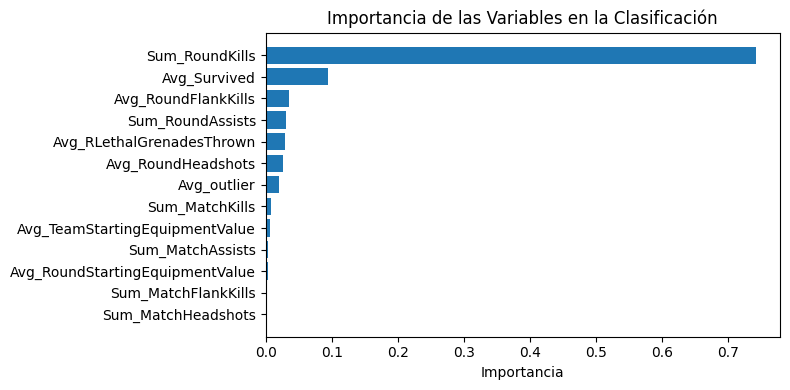

In [ ]:
plt.figure(figsize=(8, 4))
plt.barh(importancias['Variable'], importancias['Importancia'])
plt.xlabel('Importancia')
plt.title('Importancia de las Variables en la Clasificación')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


##Reporte de clasificacion


In [ ]:
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       105
           1       0.88      0.96      0.91        95

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.91       200
weighted avg       0.92      0.92      0.92       200



**1. Exactitud General (Accuracy): 0.92**
El modelo predice correctamente en el 92% de los casos.

 Con una buena precision y recall considerando de que no hay mucho falso positivo


